In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

# Vanishing/Exploding Gradients Problem 梯度消失/爆炸問題

In [3]:
def logit(z):
    return 1 / (1 + np.exp(-z))

(-5.0, 5.0, -0.2, 1.2)

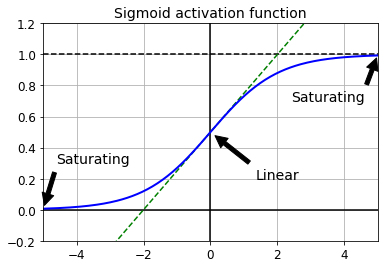

In [4]:
z = np.linspace(-5, 5, 200) #-5到5之間平均部屬200個點

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center") #註解函數
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])


當輸出變大時(不論正負),函數會在0或1時飽和,由此可知它的導數會趨近於0.
因此,當進行反向傳播時,它幾乎沒有任何梯度可以沿著網路往回傳播,而且在反向傳播過程中,倖存的些微梯度會被不斷地稀釋,
因此在低階層會得不到任何東西

# Xavier and He Initialization

In [5]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

In [6]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

In [7]:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',  #調整變異數之常態分佈
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

目的是改善梯度問題:為了讓各層訊號能正常傳遞,需要讓各層的輸出變異度等於輸入變異度,其中與要讓反向流經一層之前與之後的梯度有一樣的變異度.

觸發函數常用配對

初始化---------------觸發函數------------------------常態

Glorot-------None,tanh,logistic,softmax---------1 / fan_avg
 
--He-------------ReLu,variants------------------2 / fan_in
  
-Lecun---------------SELU-----------------------1 / fan_in

# Nonsaturating Activation Functions

## Leaky ReLU

In [8]:
def leaky_relu(z, alpha=0.01): #通常設為0.01
    return np.maximum(alpha*z, z)
#LeakyReLU(z) = max(alpha * z, z)

Saving figure leaky_relu_plot


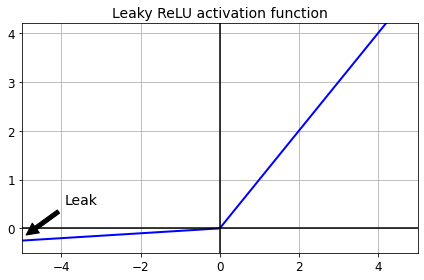

In [9]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

RReLU:訓練期間隨機選擇某個區間的alpha,測試時則固定平均值 ->>> 似乎有正歸化作用
PReLU:alpha在訓練中學習 ->>> 大型圖像效果優於ReLU 處理小型資料組時,有過擬現象

## ELU

In [10]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

#ELU(z) = alpha(exp(x) - 1), z < 0 ; z, z >= 0

Saving figure elu_plot


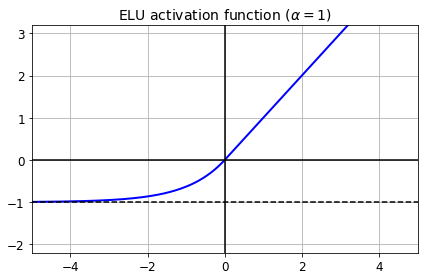

In [11]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

-> 當 z < 0, 可讓單位平均輸出趨近於零,並有效減緩梯度消失 

-> 當 z < 0, 梯度不為零,可避免神經元死亡 

-> 當 alpha 等於 1 時, 函數任何地方皆為平滑,包括 z = 0 附近,可有助於提昇梯度下降速度,因為 z = 0 附近時彈跳並不會太大

## SELU

In [12]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [13]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

Saving figure selu_plot


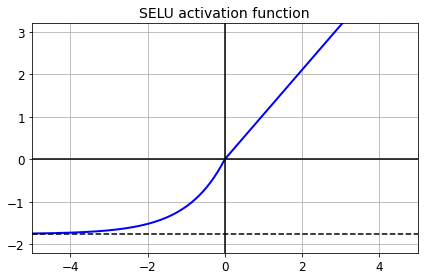

In [14]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

->網路自動正規化
->輸出保持均值為0且標準差為1
->輸入特徵必須標準化(均值為0, 標準差為1)
->權重必須執行 LeCun normal 初始化
->網路架構必須為循序的,意指遞迴網路或是跳接網路,自動正規化不一定產生

In [15]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


In [16]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [17]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [18]:
#輸入正規化
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [19]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 15s 9ms/step - loss: 1.1408 - accuracy: 0.5690 - val_loss: 0.7190 - val_accuracy: 0.7470
Epoch 2/5
1719/1719 [==============================] - 15s 9ms/step - loss: 0.6971 - accuracy: 0.7599 - val_loss: 0.6909 - val_accuracy: 0.7738
Epoch 3/5
1719/1719 [==============================] - 15s 9ms/step - loss: 0.7637 - accuracy: 0.7321 - val_loss: 0.6211 - val_accuracy: 0.7898
Epoch 4/5
1719/1719 [==============================] - 15s 9ms/step - loss: 0.5749 - accuracy: 0.8031 - val_loss: 0.7651 - val_accuracy: 0.7326
Epoch 5/5
1719/1719 [==============================] - 15s 9ms/step - loss: 0.7723 - accuracy: 0.7183 - val_loss: 0.6244 - val_accuracy: 0.7812


In [20]:
np.random.seed(42)
tf.random.set_seed(42)

In [21]:
#與ReLu相比
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [22]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [23]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 14s 8ms/step - loss: 1.8214 - accuracy: 0.2635 - val_loss: 1.4145 - val_accuracy: 0.3586
Epoch 2/5
1719/1719 [==============================] - 13s 8ms/step - loss: 1.1818 - accuracy: 0.5005 - val_loss: 0.8725 - val_accuracy: 0.6340
Epoch 3/5
1719/1719 [==============================] - 14s 8ms/step - loss: 0.9883 - accuracy: 0.6017 - val_loss: 0.9235 - val_accuracy: 0.5792
Epoch 4/5
1719/1719 [==============================] - 14s 8ms/step - loss: 0.8050 - accuracy: 0.6909 - val_loss: 0.7771 - val_accuracy: 0.7216
Epoch 5/5
1719/1719 [==============================] - 14s 8ms/step - loss: 0.6933 - accuracy: 0.7449 - val_loss: 0.7355 - val_accuracy: 0.7316


## Batch Normalization

將各個輸入中心調整為 0 並將正歸化,接著使用兩個參數向量縮放結果以及移動結果

-> 目的是為了讓模型學習各階層的輸入最佳尺度以及最佳均值

-> 放在第一層如同做標準化 (StandardScalar)

-> 測試階段通常以階層的輸入均值以及標轉差移動平均數來估計 

ex.alpha 與 Beta 在反向傳播學得. Mu 與 Sigma 為指數移動平均估計,訓練期間估計,測試期間使用

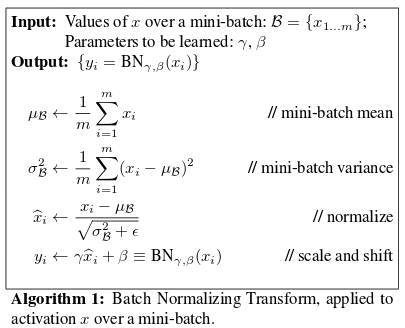

In [24]:
from tensorflow.keras.layers import Flatten, BatchNormalization, Dense
from tensorflow.keras.models import Sequential
model = Sequential([
    Flatten(input_shape=[28, 28]),
    BatchNormalization(),
    Dense(300, activation="relu"),
    BatchNormalization(),
    Dense(100, activation="relu"),
    BatchNormalization(),
    Dense(10, activation="softmax")
])

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_204 (Dense)            (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_205 (Dense)            (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_206 (Dense)            (None, 10)               

In [26]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

#4個變數

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [27]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [28]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.8750 - accuracy: 0.7124 - val_loss: 0.5525 - val_accuracy: 0.8230
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5753 - accuracy: 0.8029 - val_loss: 0.4724 - val_accuracy: 0.8472
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5189 - accuracy: 0.8205 - val_loss: 0.4376 - val_accuracy: 0.8550
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4827 - accuracy: 0.8323 - val_loss: 0.4151 - val_accuracy: 0.8600
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4565 - accuracy: 0.8407 - val_loss: 0.3996 - val_accuracy: 0.8642
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4398 - accuracy: 0.8470 - val_loss: 0.3867 - val_accuracy: 0.8696
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4242 - accuracy: 0.8515 - val_loss: 0.3762 - val_accuracy:

## Gradient Clipping 梯度修剪

限制梯度不高於一個閾值

-> 常用於遞迴神經網路

In [29]:
optimizer = keras.optimizers.SGD(clipvalue=1.0) #修剪值_[0.9, 0.1] <- [0.9, 100]

In [30]:
optimizer = keras.optimizers.SGD(clipnorm=1.0) #修剪範數_[0.00899964, 0.9999595] <- [0.9, 100]

# Reusing Pretrained Layers

In [31]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [32]:
X_train_A.shape

(43986, 28, 28)

In [33]:
X_train_B.shape

(200, 28, 28)

In [34]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [35]:
y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [36]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [37]:
model_A.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_207 (Dense)            (None, 300)               235500    
_________________________________________________________________
dense_208 (Dense)            (None, 100)               30100     
_________________________________________________________________
dense_209 (Dense)            (None, 50)                5050      
_________________________________________________________________
dense_210 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_211 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_212 (Dense)            (None, 8)                

In [38]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [39]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.5717 - accuracy: 0.8158 - val_loss: 0.3923 - val_accuracy: 0.8597
Epoch 2/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.3552 - accuracy: 0.8761 - val_loss: 0.3326 - val_accuracy: 0.8866
Epoch 3/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.3188 - accuracy: 0.8887 - val_loss: 0.3048 - val_accuracy: 0.8946
Epoch 4/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.2995 - accuracy: 0.8946 - val_loss: 0.2923 - val_accuracy: 0.8994
Epoch 5/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.2862 - accuracy: 0.8997 - val_loss: 0.2801 - val_accuracy: 0.9031
Epoch 6/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.2760 - accuracy: 0.9037 - val_loss: 0.2736 - val_accuracy: 0.9063
Epoch 7/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.2675 - accuracy: 0.9069 - val_loss: 0.2713 - val_accuracy:

In [40]:
model_A.save("my_model_A.h5")

In [41]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid")) #model_A -> softmax

In [42]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [43]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 0s 15ms/step - loss: 0.7409 - accuracy: 0.5050 - val_loss: 0.5198 - val_accuracy: 0.7525
Epoch 2/20
7/7 [==============================] - 0s 6ms/step - loss: 0.4760 - accuracy: 0.8000 - val_loss: 0.4020 - val_accuracy: 0.8580
Epoch 3/20
7/7 [==============================] - 0s 5ms/step - loss: 0.3666 - accuracy: 0.8850 - val_loss: 0.3294 - val_accuracy: 0.9209
Epoch 4/20
7/7 [==============================] - 0s 5ms/step - loss: 0.2978 - accuracy: 0.9400 - val_loss: 0.2820 - val_accuracy: 0.9391
Epoch 5/20
7/7 [==============================] - 0s 5ms/step - loss: 0.2532 - accuracy: 0.9450 - val_loss: 0.2480 - val_accuracy: 0.9483
Epoch 6/20
7/7 [==============================] - 0s 5ms/step - loss: 0.2202 - accuracy: 0.9650 - val_loss: 0.2220 - val_accuracy: 0.9574
Epoch 7/20
7/7 [==============================] - 0s 6ms/step - loss: 0.1947 - accuracy: 0.9800 - val_loss: 0.2035 - val_accuracy: 0.9564
Epoch 8/20
7/7 [=================

In [44]:
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1]) #去除輸出層
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [45]:
model_A_clone = keras.models.clone_model(model_A) #複製結構
model_A_clone.set_weights(model_A.get_weights())  #複製權重

In [46]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False #凍結輸出層以外

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])

In [47]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 0s 14ms/step - loss: 0.9741 - accuracy: 0.3150 - val_loss: 0.9189 - val_accuracy: 0.3600
Epoch 2/4
7/7 [==============================] - 0s 5ms/step - loss: 0.8919 - accuracy: 0.3600 - val_loss: 0.8483 - val_accuracy: 0.4097
Epoch 3/4
7/7 [==============================] - 0s 5ms/step - loss: 0.8225 - accuracy: 0.4000 - val_loss: 0.7841 - val_accuracy: 0.4716
Epoch 4/4
7/7 [==============================] - 0s 5ms/step - loss: 0.7593 - accuracy: 0.4700 - val_loss: 0.7257 - val_accuracy: 0.5243
Epoch 1/16
7/7 [==============================] - 0s 15ms/step - loss: 0.5990 - accuracy: 0.6750 - val_loss: 0.4526 - val_accuracy: 0.8327
Epoch 2/16
7/7 [==============================] - 0s 6ms/step - loss: 0.3850 - accuracy: 0.8600 - val_loss: 0.3376 - val_accuracy: 0.9006
Epoch 3/16
7/7 [==============================] - 0s 5ms/step - loss: 0.2863 - accuracy: 0.9300 - val_loss: 0.2674 - val_accuracy: 0.9249
Epoch 4/16
7/7 [====================

In [48]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 647us/step - loss: 0.1047 - accuracy: 0.9745


[0.10467366874217987, 0.9745000004768372]

In [49]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 709us/step - loss: 0.0822 - accuracy: 0.9875


[0.08223219960927963, 0.987500011920929]

# Learning Rate Scheduling

## Power Scheduling

lr = lr0 / (1 + steps / s)**c

-> Keras uses c=1 and s = 1 / decay

In [50]:
optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-4)

In [53]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [54]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4878 - accuracy: 0.8275 - val_loss: 0.4110 - val_accuracy: 0.8562
Epoch 2/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3803 - accuracy: 0.8666 - val_loss: 0.3771 - val_accuracy: 0.8670
Epoch 3/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3478 - accuracy: 0.8759 - val_loss: 0.3789 - val_accuracy: 0.8692
Epoch 4/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3268 - accuracy: 0.8835 - val_loss: 0.3562 - val_accuracy: 0.8796
Epoch 5/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3119 - accuracy: 0.8897 - val_loss: 0.3496 - val_accuracy: 0.8772
Epoch 6/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2979 - accuracy: 0.8931 - val_loss: 0.3485 - val_accuracy: 0.8796
Epoch 7/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2882 - accuracy: 0.8973 - val_loss: 0.3434 - val_accuracy:

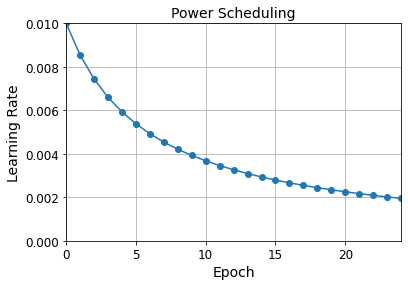

In [55]:
learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = len(X_train) // batch_size
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

## Exponential Scheduling

lr = lr0 * 0.1**(epoch / s)

In [56]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [57]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2042 - accuracy: 0.9295 - val_loss: 0.3233 - val_accuracy: 0.8880
Epoch 2/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2012 - accuracy: 0.9302 - val_loss: 0.3229 - val_accuracy: 0.8876
Epoch 3/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.1985 - accuracy: 0.9320 - val_loss: 0.3260 - val_accuracy: 0.8854
Epoch 4/25
1719/1719 [==============================] - 2s 998us/step - loss: 0.1962 - accuracy: 0.9332 - val_loss: 0.3211 - val_accuracy: 0.8904
Epoch 5/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.1949 - accuracy: 0.9335 - val_loss: 0.3226 - val_accuracy: 0.8858
Epoch 6/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.1929 - accuracy: 0.9339 - val_loss: 0.3218 - val_accuracy: 0.8868
Epoch 7/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.1914 - accuracy: 0.9352 - val_loss: 0.3212 - val_accurac

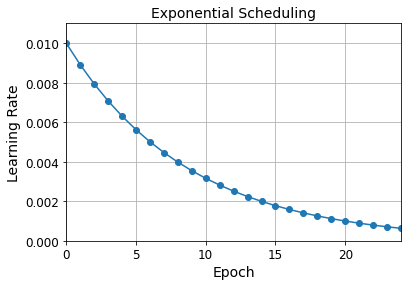

In [58]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

每一步都更新學習率

In [59]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch-> batch在每一個epoch都會重置
        lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, lr * 0.1**(1 / s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 0.01
optimizer = keras.optimizers.Nadam(lr=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25

s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[exp_decay])

Epoch 1/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.7849 - accuracy: 0.7695 - val_loss: 0.7286 - val_accuracy: 0.7850
Epoch 2/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6216 - accuracy: 0.8061 - val_loss: 0.5253 - val_accuracy: 0.8374
Epoch 3/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5888 - accuracy: 0.8197 - val_loss: 0.8703 - val_accuracy: 0.7780
Epoch 4/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5371 - accuracy: 0.8345 - val_loss: 0.4891 - val_accuracy: 0.8638
Epoch 5/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4654 - accuracy: 0.8535 - val_loss: 0.4679 - val_accuracy: 0.8676
Epoch 6/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4292 - accuracy: 0.8628 - val_loss: 0.5337 - val_accuracy: 0.8566
Epoch 7/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3999 - accuracy: 0.8723 - val_loss: 0.5200 - val_accuracy:

In [60]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

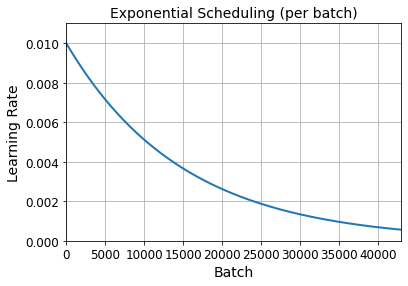

In [61]:

plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

## Piecewise Constant Scheduling

In [62]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [63]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [64]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.8506 - accuracy: 0.7556 - val_loss: 1.2367 - val_accuracy: 0.6872
Epoch 2/25
1719/1719 [==============================] - 3s 2ms/step - loss: 1.0989 - accuracy: 0.6771 - val_loss: 0.8387 - val_accuracy: 0.6984
Epoch 3/25
1719/1719 [==============================] - 3s 2ms/step - loss: 1.0594 - accuracy: 0.6540 - val_loss: 1.3572 - val_accuracy: 0.5358
Epoch 4/25
1719/1719 [==============================] - 3s 2ms/step - loss: 1.1402 - accuracy: 0.6099 - val_loss: 1.0485 - val_accuracy: 0.6162
Epoch 5/25
1719/1719 [==============================] - 3s 2ms/step - loss: 1.1477 - accuracy: 0.6089 - val_loss: 1.4417 - val_accuracy: 0.5726
Epoch 6/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.8656 - accuracy: 0.6599 - val_loss: 0.8649 - val_accuracy: 0.6780
Epoch 7/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.7992 - accuracy: 0.6815 - val_loss: 0.8295 - val_accuracy:

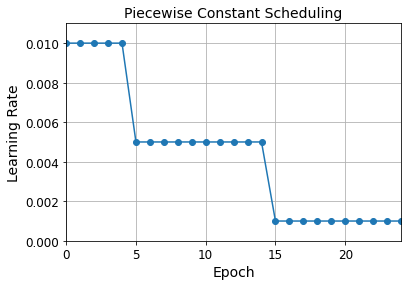

In [65]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

## Performance Scheduling

每N步評估驗證誤差,在誤差停止下降時,降低學習率

In [66]:
tf.random.set_seed(42)
np.random.seed(42)

In [67]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5887 - accuracy: 0.8079 - val_loss: 0.4636 - val_accuracy: 0.8522
Epoch 2/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4996 - accuracy: 0.8404 - val_loss: 0.5860 - val_accuracy: 0.8412
Epoch 3/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5103 - accuracy: 0.8415 - val_loss: 0.4829 - val_accuracy: 0.8542
Epoch 4/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5030 - accuracy: 0.8506 - val_loss: 0.5069 - val_accuracy: 0.8486
Epoch 5/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5247 - accuracy: 0.8484 - val_loss: 0.4871 - val_accuracy: 0.8490
Epoch 6/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5100 - accuracy: 0.8538 - val_loss: 0.6440 - val_accuracy: 0.8402
Epoch 7/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2993 - accuracy: 0.8947 - val_loss: 0.3723 - val_accuracy:

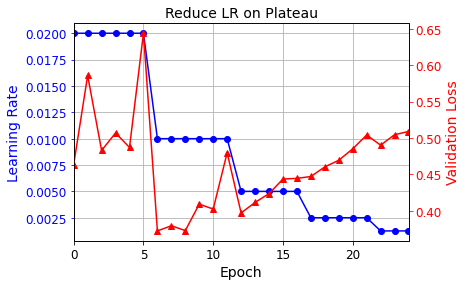

In [68]:

plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()


## 1Cycle scheduling

先增加初始學習率 -> 訓練前段線性提昇至n1 -> 訓練後段降低至n2 -> 最後急速下降

In [69]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = len(X) // batch_size * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [70]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

430/430 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.3861


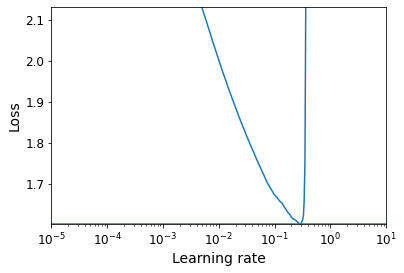

In [71]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [72]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [73]:
n_epochs = 25
onecycle = OneCycleScheduler(len(X_train) // batch_size * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 [==============================] - 1s 2ms/step - loss: 0.6572 - accuracy: 0.7740 - val_loss: 0.4872 - val_accuracy: 0.8338
Epoch 2/25
430/430 [==============================] - 1s 2ms/step - loss: 0.4580 - accuracy: 0.8397 - val_loss: 0.4275 - val_accuracy: 0.8520
Epoch 3/25
430/430 [==============================] - 1s 2ms/step - loss: 0.4121 - accuracy: 0.8548 - val_loss: 0.4115 - val_accuracy: 0.8584
Epoch 4/25
430/430 [==============================] - 1s 2ms/step - loss: 0.3837 - accuracy: 0.8641 - val_loss: 0.3869 - val_accuracy: 0.8684
Epoch 5/25
430/430 [==============================] - 1s 2ms/step - loss: 0.3639 - accuracy: 0.8717 - val_loss: 0.3765 - val_accuracy: 0.8682
Epoch 6/25
430/430 [==============================] - 1s 2ms/step - loss: 0.3456 - accuracy: 0.8772 - val_loss: 0.3745 - val_accuracy: 0.8706
Epoch 7/25
430/430 [==============================] - 1s 2ms/step - loss: 0.3329 - accuracy: 0.8812 - val_loss: 0.3632 - val_accuracy: 0.8720
Epoch 

# 用正規化避免過擬合

## $\ell_1$ and $\ell_2$ regularization

訓練時為了擬合好，會產生很多高次項，但反而容易被雜訊干擾(overfitting)，L1/L2為讓Loss Function更平滑，抗雜訊干擾能力越大。

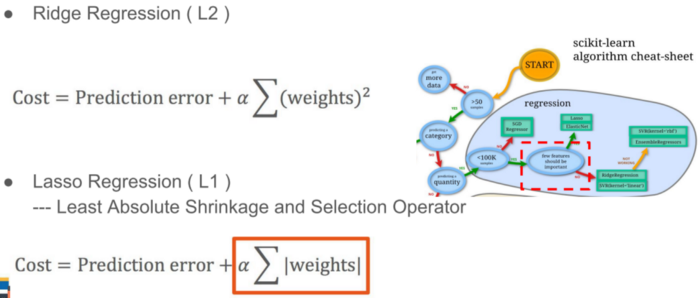

Lasso(L1) Regularization相較於Ridge(L2) Regularization會產生較多零的
coefficient，這個特性可以用來做重要Feature Extraction。

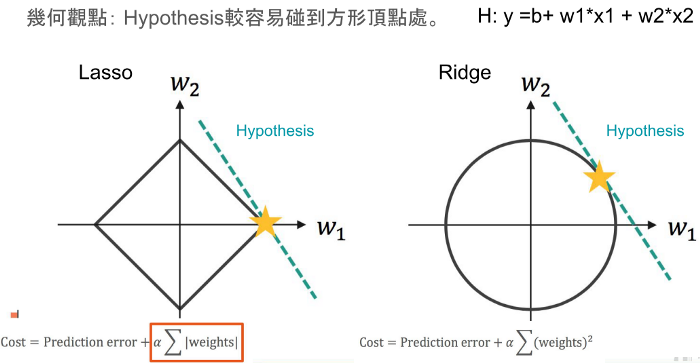

In [74]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
# or l1(0.1) for ℓ1 regularization with a factor or 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

In [75]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 4s 2ms/step - loss: 1.5956 - accuracy: 0.8124 - val_loss: 0.7169 - val_accuracy: 0.8340
Epoch 2/2
1719/1719 [==============================] - 4s 2ms/step - loss: 0.7197 - accuracy: 0.8274 - val_loss: 0.6850 - val_accuracy: 0.8376


In [76]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 4s 2ms/step - loss: 1.6313 - accuracy: 0.8113 - val_loss: 0.7218 - val_accuracy: 0.8310
Epoch 2/2
1719/1719 [==============================] - 4s 2ms/step - loss: 0.7187 - accuracy: 0.8273 - val_loss: 0.6826 - val_accuracy: 0.8382


## Dropout

In [77]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2), 
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2), 
    keras.layers.Dense(10, activation="softmax"),
])

In [79]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                   validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5838 - accuracy: 0.7997 - val_loss: 0.3730 - val_accuracy: 0.8644
Epoch 2/2
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4209 - accuracy: 0.8442 - val_loss: 0.3396 - val_accuracy: 0.8720


## Alpha Dropout

In [80]:
tf.random.set_seed(42)
np.random.seed(42)

In [81]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6654 - accuracy: 0.7599 - val_loss: 0.5935 - val_accuracy: 0.8420
Epoch 2/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5607 - accuracy: 0.7931 - val_loss: 0.5579 - val_accuracy: 0.8404
Epoch 3/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5283 - accuracy: 0.8053 - val_loss: 0.4814 - val_accuracy: 0.8592
Epoch 4/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5072 - accuracy: 0.8117 - val_loss: 0.4597 - val_accuracy: 0.8584
Epoch 5/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4922 - accuracy: 0.8177 - val_loss: 0.4596 - val_accuracy: 0.8580
Epoch 6/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4871 - accuracy: 0.8196 - val_loss: 0.4776 - val_accuracy: 0.8592
Epoch 7/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4717 - accuracy: 0.8241 - val_loss: 0.4662 - val_accuracy:

In [82]:
model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 0s 665us/step - loss: 0.4436 - accuracy: 0.8682


[0.4435723125934601, 0.8682000041007996]

In [83]:
model.evaluate(X_train_scaled, y_train)

1719/1719 [==============================] - 1s 652us/step - loss: 0.3300 - accuracy: 0.8903


[0.32995855808258057, 0.8902909159660339]

## MC Dropout

In [84]:
tf.random.set_seed(42)
np.random.seed(42)

In [85]:
y_probas = np.stack([model(X_test_scaled, training=True) #dropout 不管是訓練或測試接打開
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)

np.stack ->

import numpy as np
a=[[1,2,3],
   [4,5,6]]
print("列表a如下：")
print(a)

print("增加一维，新维度的下標為0")
c=np.stack(a,axis=0)
print(c)

print("增加一维，新维度的下標為1")
c=np.stack(a,axis=1)
print(c)

輸出：
列表a如下：
[[1, 2, 3], [4, 5, 6]]
增加一维，新维度下標為0
[[1 2 3]
 [4 5 6]]
增加一维，新维度下標為1
[[1 4]
 [2 5]
 [3 6]]

In [88]:
np.round(model.predict(X_test_scaled[:1]), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.01, 0.  , 0.96]],
      dtype=float32)

 np.around ->
 
 返回四捨五入之值,可指定精度

In [89]:
np.round(y_probas[:, :1], 2)

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.41, 0.  , 0.39, 0.  , 0.2 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.47, 0.  , 0.51]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.65, 0.  , 0.02, 0.  , 0.33]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.09, 0.  , 0.39, 0.  , 0.52]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.27, 0.  , 0.55, 0.  , 0.18]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.45, 0.  , 0.55]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.35, 0.  , 0.22, 0.  , 0.43]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.44, 0.  , 0.55]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.53, 0.  , 0.08, 0.  , 0.39]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.08, 0.  , 0.04, 0.  , 0.89]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.43, 0.  , 0.55]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.87, 0.  , 0.05, 0.  , 0.08]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.85, 0.  , 0.09, 0.  , 0.07]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.35, 0.  , 0.41, 0.  , 0

In [90]:
np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.3 , 0.  , 0.19, 0.  , 0.51]],
      dtype=float32)

In [91]:
y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.28, 0.  , 0.17, 0.  , 0.29]],
      dtype=float32)

In [92]:
y_pred = np.argmax(y_proba, axis=1)

In [93]:
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.8655

In [94]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [95]:
tf.random.set_seed(42)
np.random.seed(42)

In [96]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [97]:
mc_model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_14 (Flatten)         (None, 784)               0         
_________________________________________________________________
mc_alpha_dropout (MCAlphaDro (None, 784)               0         
_________________________________________________________________
dense_248 (Dense)            (None, 300)               235500    
_________________________________________________________________
mc_alpha_dropout_1 (MCAlphaD (None, 300)               0         
_________________________________________________________________
dense_249 (Dense)            (None, 100)               30100     
_________________________________________________________________
mc_alpha_dropout_2 (MCAlphaD (None, 100)               0         
_________________________________________________________________
dense_250 (Dense)            (None, 10)              

In [100]:
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
mc_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [101]:
mc_model.set_weights(model.get_weights())

In [102]:
np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis=0), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.27, 0.  , 0.21, 0.  , 0.52]],
      dtype=float32)

## Max norm

In [103]:
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

In [104]:
MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4740 - accuracy: 0.8328 - val_loss: 0.3745 - val_accuracy: 0.8646
Epoch 2/2
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3552 - accuracy: 0.8707 - val_loss: 0.3683 - val_accuracy: 0.8672
